In [22]:
from confirm.outlaw.nb_util import setup_nb

setup_nb()
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from confirm.mini_imprint import batch, grid, adagrid, driver, db

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
@jax.jit
def _sim(samples, theta, null_truth):
    return jnp.where(
        null_truth[:, None, 0],
        # negate so that we can do a less than comparison
        -(theta[:, None, 0] + samples[None, :]),
        jnp.inf,
    )


class ZTest1D:
    def __init__(self, seed, max_K, sim_batch_size=2048):
        self.family = "normal"
        self.sim_batch_size = sim_batch_size
        self.dtype = jnp.float32

        # sample normals and then compute the CDF to transform into the
        # interval [0, 1]
        key = jax.random.PRNGKey(seed)
        self.samples = jax.random.normal(key, shape=(max_K,), dtype=self.dtype)
        self._sim_batch = batch.batch(
            _sim, self.sim_batch_size, in_axes=(0, None, None), out_axes=(1,)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        return self._sim_batch(self.samples[begin_sim:end_sim], theta, null_truth)

## Calculate Type I Error

In [5]:
K = 8192
model = ZTest1D(seed=0, max_K=K)

N = 100
theta, radii = grid.cartesian_gridpts([-1], [1], [N])
g = grid.init_grid(theta, radii, K).add_null_hypo(0).prune()

# TODO: is there any problem from using the same seed with the bootstrap
# indices and the simulations?
dd = driver.Driver(model)

In [13]:
g.df.nlargest(10, "theta0")

,K,theta0,radii0,grid_pt_idx,parent_idx,birthday,null_truth0
49,8192,-0.01,0.01,49,-1,0,True
48,8192,-0.03,0.01,48,-1,0,True
47,8192,-0.05,0.01,47,-1,0,True
46,8192,-0.07,0.01,46,-1,0,True
45,8192,-0.09,0.01,45,-1,0,True
44,8192,-0.11,0.01,44,-1,0,True
43,8192,-0.13,0.01,43,-1,0,True
42,8192,-0.15,0.01,42,-1,0,True
41,8192,-0.17,0.01,41,-1,0,True
40,8192,-0.19,0.01,40,-1,0,True


In [14]:
# lam = -1.96 because we negated the statistics so we can do a less thanj
# comparison.
rej_df = dd.rej(g, -1.96)

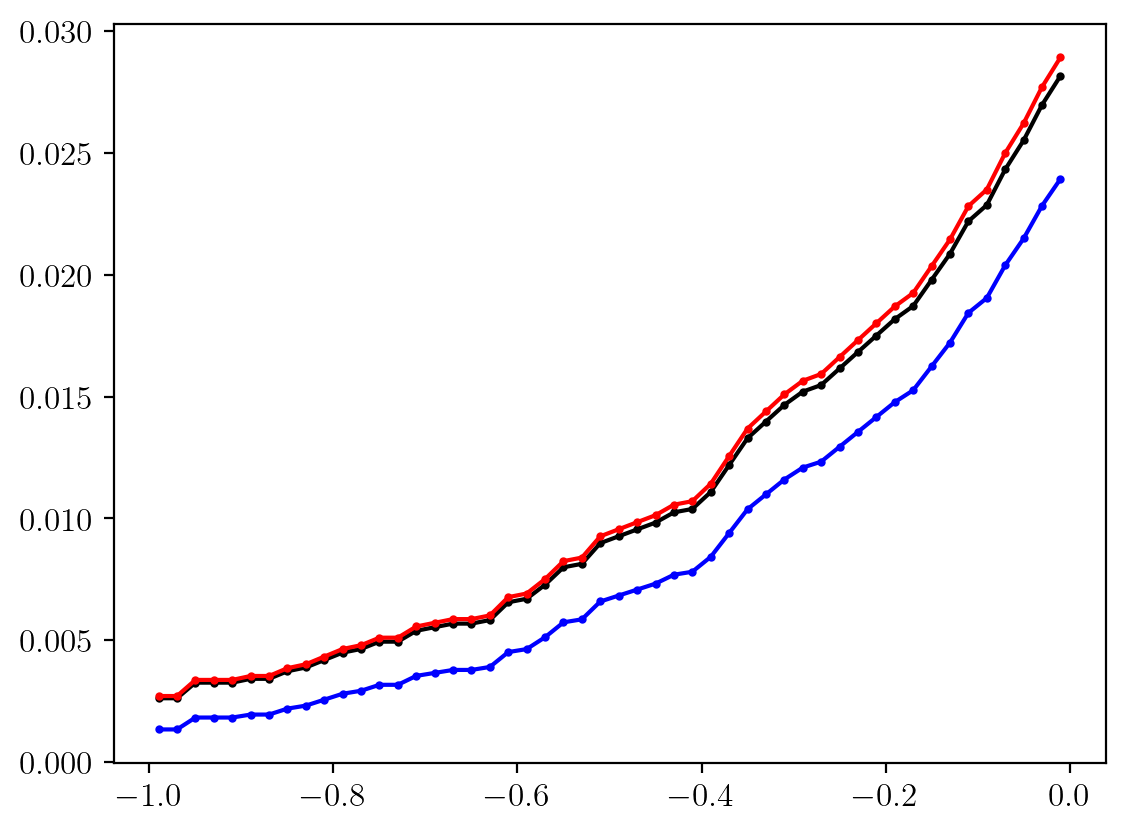

In [15]:
plt.plot(g.df["theta0"], rej_df["TI_est"], "b-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_cp_bound"], "k-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_bound"], "r-o", markersize=2)
plt.show()

## Adagrid Tuning

In [18]:
init_K = 2048
n_K_double = 4
model = ZTest1D(seed=1, max_K=init_K * 2**n_K_double)


N = 10
theta, radii = grid.cartesian_gridpts([-1], [1], [N])
g = grid.init_grid(theta, radii, init_K).add_null_hypo(0).prune()

nB = 6
tuning_min_idx = 20
ada = adagrid.AdagridDriver(model, init_K, n_K_double, nB, bootstrap_seed=2)

In [24]:
df_tune = ada.bootstrap_tune(g)
g_tune = g.add_cols(df_tune)

In [62]:
tiledb = db.DuckDBTiles.create(g_tune)

In [63]:
tiledb.bias()

0.022227982680002922

6

In [20]:
df_tune.iloc[df_tune["lams"].argmin()]

alpha0           0.018959
lams            -1.971155
B_lams0         -1.889221
B_lams1         -2.027906
B_lams2         -2.009917
B_lams3         -2.075302
B_lams4         -1.948035
B_lams5         -2.009917
twb_lams0       -1.971155
twb_lams1       -1.923354
twb_lams2       -2.100269
twb_lams3       -2.009917
twb_lams4       -2.053523
twb_lams5       -1.867425
twb_min_lams    -2.100269
twb_mean_lams   -1.987607
twb_max_lams    -1.867425
Name: 5, dtype: float64

In [8]:
lams_bias = (
    df_tune["lams"].min(axis=0)
    - df_tune[[f"B_lams{i}" for i in range(nB)]].values.min(axis=0).mean()
)
lams_bias

0.022227982680002922

In [22]:
def f(x):
    return df_tune.iloc[x]

,alpha0,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_min_lams,twb_mean_lams,twb_max_lams
1,0.018959,-1.371155,-1.289221,-1.427906,-1.409917,-1.475302,-1.348035,-1.409917,-1.371155,-1.323354,-1.500269,-1.409917,-1.453523,-1.267425,-1.500269,-1.387607,-1.267425
2,0.018959,-1.571155,-1.489221,-1.627906,-1.609917,-1.675302,-1.548035,-1.609917,-1.571155,-1.523354,-1.700269,-1.609917,-1.653523,-1.467425,-1.700269,-1.587607,-1.467425


In [9]:
dd.stats(g).apply()

TypeError: Series.apply() missing 1 required positional argument: 'func'

In [80]:
df_tune["impossible"] = df_tune["alpha0"] < (tuning_min_idx + 1) / (g.df["K"] + 1)

In [81]:
df_tune[["twb_min_lams", "twb_mean_lams", "twb_max_lams", "lams"]]

,twb_min_lams,twb_mean_lams,twb_max_lams,lams
0,-1.227906,-1.15286,-1.089221,-1.171155
1,-1.427906,-1.35286,-1.289221,-1.371155
2,-1.627906,-1.55286,-1.489221,-1.571155
3,-1.827906,-1.75286,-1.689221,-1.771155
5,-2.027906,-1.95286,-1.889221,-1.971155


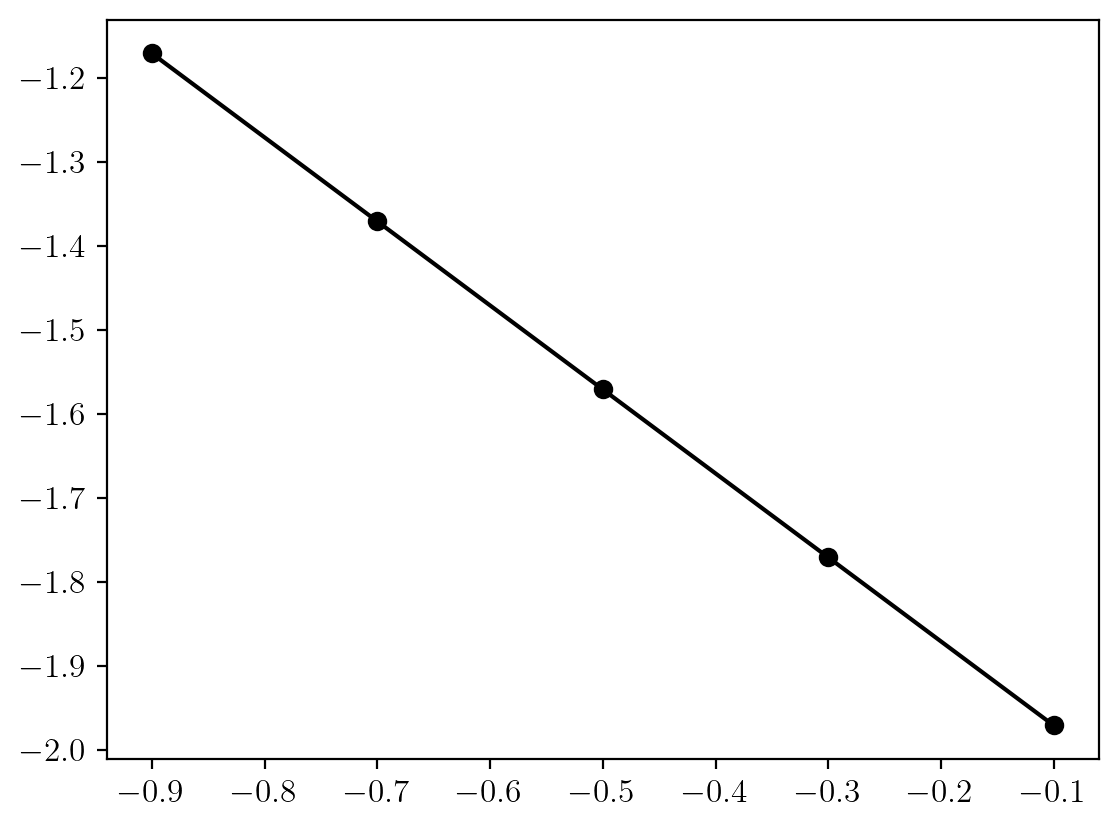

In [75]:
plt.plot(g.df["theta0"], df_tune["lams"], "k-o")
plt.show()

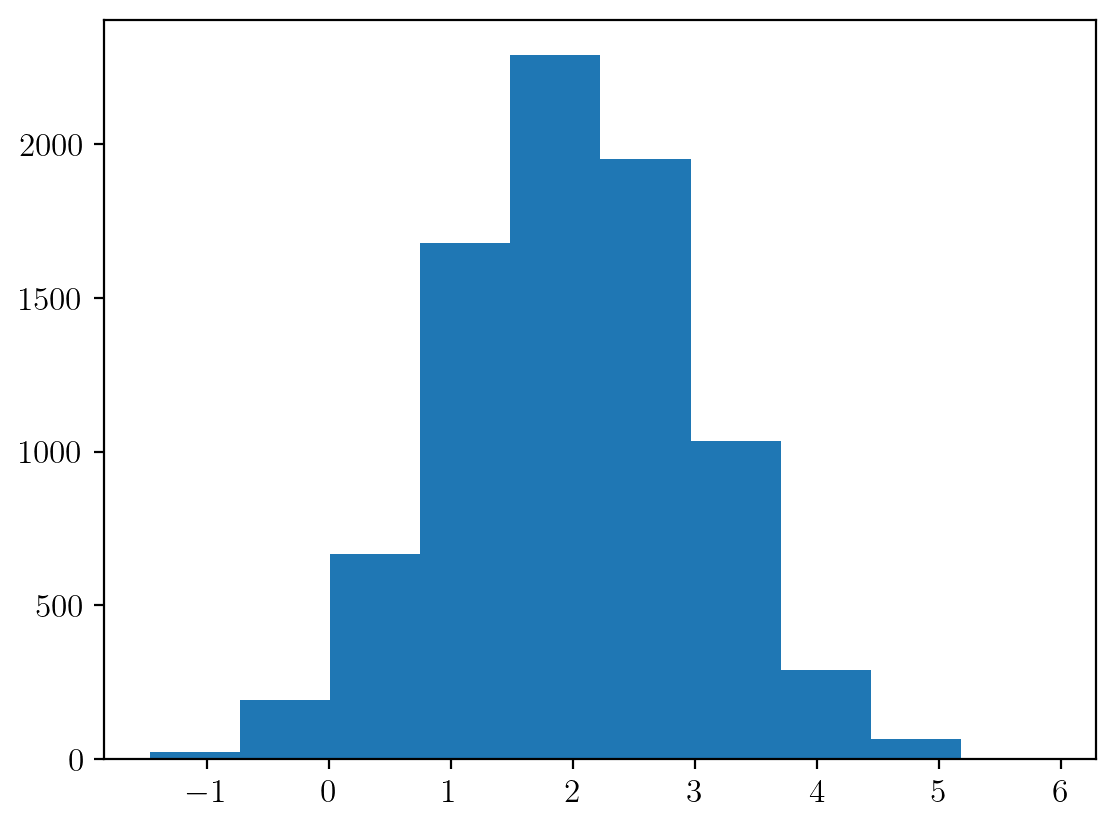

In [ ]:
import matplotlib.pyplot as plt

stats = dd.stats(g).iloc[0]
plt.hist(stats[0])
plt.show()